In [ ]:
import os 
os.environ['TF_KERAS'] = '1'
%env TF_KERAS = 1
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, BinaryAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau


import random

from imutils import paths
import numpy as np
import pandas as pd
import skimage as sk
import skimage.transform
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, roc_curve
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
import ssl

from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Concatenate, Dense, Dropout, Flatten, Input
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D


env: TF_KERAS=1


In [ ]:
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf




def show_raw_image(img) -> None:
    """
    Displays a PIL image.
    :param img: the image in PIL format (before being converted to an array).
    :return: None.
    """
    img.show()




def create_label_encoder():
   
    return LabelEncoder()

In [ ]:

# Constants
RANDOM_SEED = 111
VGG_IMG_SIZE = {
    "HEIGHT": 512,
    "WIDTH": 512
}
VGG_IMG_SIZE_LARGE = {
    "HEIGHT": 2048,
    "WIDTH": 2048
}
BATCH_SIZE = 2
EPOCH_1 = 150
EPOCH_2 = 50

# Variables set by command line arguments/flags
dataset = "mini-MIAS"   # The dataset to use.
model = "advanced"         # The model to use.
run_mode = "training"   # The type of running mode, either training or testing.
verbose_mode = False    # Boolean used to print additional logs for debugging purposes.
imagesize = "small"


In [ ]:

def preprocess_image(image_path: str) -> np.ndarray:
 
    image = load_img(image_path,
                     color_mode="grayscale",
                     target_size=(VGG_IMG_SIZE['HEIGHT'], VGG_IMG_SIZE["WIDTH"]))
    image = img_to_array(image)
    image /= 255.0
    return image

def encode_labels(labels_list: np.ndarray, label_encoder) -> np.ndarray:
  
    labels = label_encoder.fit_transform(labels_list)
    if label_encoder.classes_.size == 2:
        return labels
    else:
        return to_categorical(labels)

def dataset_stratified_split(split: float, dataset: np.ndarray, labels: np.ndarray) -> \
        (np.ndarray, np.ndarray, np.ndarray, np.ndarray):
    
    train_X, test_X, train_Y, test_Y = train_test_split(dataset,
                                                        labels,
                                                        test_size=split,
                                                        stratify=labels,
                                                        random_state=RANDOM_SEED,
                                                        shuffle=True)
    return train_X, test_X, train_Y, test_Y


def random_rotation(image_array: np.ndarray):
    """
    Randomly rotate the image
    :param image_array: input image
    :return: randomly rotated image
    """
    random_degree = random.uniform(-20, 20)
    return sk.transform.rotate(image_array, random_degree)


def random_noise(image_array: np.ndarray):
    """
    Add random noise to image
    :param image_array: input image
    :return: image with added random noise
    """
    return sk.util.random_noise(image_array)


def horizontal_flip(image_array: np.ndarray):
    """
    Flip image
    :param image_array: input image
    :return: horizantally flipped image
    """
    return image_array[:, ::-1]




def create_individual_transform(image: np.array, transforms: dict):
    """
    Create transformation of an individual image
    :param image: input image
    :param transforms: the possible transforms to do on the image
    :return: transformed image
    """
    num_transformations_to_apply = random.randint(1, len(transforms))
    num_transforms = 0
    transformed_image = None
    while num_transforms <= num_transformations_to_apply:
        key = random.choice(list(transforms))
        transformed_image = transforms[key](image)
        num_transforms += 1

    return transformed_image


def get_class_balances(y_vals):
    """
    Count occurrences of each class.
    :param y_vals: labels
    :return: array count of each class
    """
    num_classes = len(y_vals[0])
    counts = np.zeros(num_classes)
    for y_val in y_vals:
        for i in range(num_classes):
            counts[i] += y_val[i]

    return (counts.tolist())



def import_minimias_dataset(data_dir: str, label_encoder) -> (np.ndarray, np.ndarray):
    """
    Import the dataset by pre-processing the images and encoding the labels.
    :param data_dir: Directory to the mini-MIAS images.
    :param label_encoder: The label encoder.
    :return: Two NumPy arrays, one for the processed images and one for the encoded labels.
    """
    # Initialise variables.
    images = list()
    labels = list()

    for image_path in list(paths.list_images(data_dir)):
        images.append(preprocess_image(image_path))
        labels.append(image_path.split(os.path.sep)[-2])  # Extract label from path.

    images = np.array(images, dtype="float32")  # Convert images to a batch.
    classes=labels
    labels = np.array(labels)

    # Encode labels.
    labels = encode_labels(labels, label_encoder)

    return images, labels, classes

In [ ]:
def generate_image_transforms(images, labels):
    """
    oversample data by tranforming existing images
    :param images: input images
    :param labels: input labels
    :return: updated list of images and labels with extra transformed images and labels
    """
    images_with_transforms = images
    labels_with_transforms = labels

    available_transforms = {'rotate': random_rotation,
                            'noise': random_noise,
                            'horizontal_flip': horizontal_flip}

    class_balance = get_class_balances(labels)
    max_count = max(class_balance)
    to_add = [max_count - i for i in class_balance]

    for i in range(len(to_add)):
        if int(to_add[i]) == 0:
            continue
        label = np.zeros(len(to_add))
        label[i] = 1
        indices = [j for j, x in enumerate(labels) if np.array_equal(x, label)]
        indiv_class_images = [images[j] for j in indices]

        for k in range(int(to_add[i])):
            a = create_individual_transform(indiv_class_images[k % len(indiv_class_images)], available_transforms)
            transformed_image = create_individual_transform(indiv_class_images[k % len(indiv_class_images)],
                                                            available_transforms)
            transformed_image = transformed_image.reshape(1, VGG_IMG_SIZE['HEIGHT'],
                                                          VGG_IMG_SIZE['WIDTH'], 1)

            images_with_transforms = np.append(images_with_transforms, transformed_image, axis=0)
            transformed_label = label.reshape(1, len(label))
            labels_with_transforms = np.append(labels_with_transforms, transformed_label, axis=0)

    return images_with_transforms, labels_with_transforms





In [ ]:
l_e = create_label_encoder()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
images, labels,classes = import_minimias_dataset(data_dir="/content/drive/MyDrive/Pec_removed_mini_mias".format("mini-MIAS"),
                                                     label_encoder=l_e)


In [ ]:
X_train, X_test, y_train, y_test = dataset_stratified_split(split=0.20, dataset=images, labels=labels)
X_train_rebalanced, y_train_rebalanced = generate_image_transforms(X_train, y_train)
X_train, X_val, y_train, y_val = dataset_stratified_split(split=0.25, dataset=X_train_rebalanced,
                                                                      labels=y_train_rebalanced)

In [ ]:
import pandas as pd
classes=pd.DataFrame(classes)
classes[0].value_counts()

normal_cases       171
benign_cases        51
malignant_cases     48
Name: 0, dtype: int64

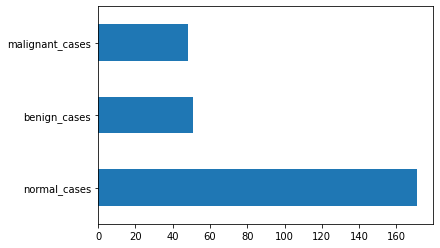

In [ ]:
classes[0].value_counts()[:20].plot(kind='barh')


In [ ]:
ssl._create_default_https_context = ssl._create_unverified_context


def generate_vgg_model(classes_len: int):
    """
    Function to create a VGG19 model pre-trained with custom FC Layers.
    If the "advanced" command line argument is selected, adds an extra convolutional layer with extra filters to support
    larger images.
    :param classes_len: The number of classes (labels).
    :return: The VGG19 model.
    """
    img_input = Input(shape=(512, 512, 1))
    img_conc = Concatenate()([img_input, img_input, img_input])

    model_base = VGG19(include_top=False, weights='imagenet', input_tensor=img_conc)

    model = Sequential()
    model.add(model_base)

    if model == "advanced":
        model.add(Conv2D(512, (3, 3),
                         activation='relu',
                         padding='same'))
        model.add(Conv2D(512, (3, 3),
                         activation='relu',
                         padding='same'))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Flatten())

    model.add(Dense(units=512, activation='relu', name='Dense_Intermediate_1'))
    model.add(Dense(units=32, activation='relu', name='Dense_Intermediate_2'))

   
    if classes_len == 2:
        model.add(Dense(1, activation='sigmoid', name='Output'))
    else:
        model.add(Dense(classes_len, activation='softmax', name='Output'))

    if verbose_mode:
        print(model.summary())

    return model


In [ ]:
model = generate_vgg_model(l_e.classes_.size)


80150528/80134624 [==============================] - 0s 0us/step


In [ ]:

    # Freeze VGG19 pre-trained layers.
   
model.layers[0].trainable = False

    # Train model with frozen layers (all training with early stopping dictated by loss in validation over 3 runs).


model.compile(optimizer='adam',loss=CategoricalCrossentropy(),metrics=[CategoricalAccuracy()])
hist = model.fit(X_train,
                 y_train,
                 validation_data=(X_val, y_val),

                 epochs=50,
                 batch_size=64,
                 )
    


Epoch 1/50
5/5 [==============================] - 89s 11s/step - loss: 23.2746 - categorical_accuracy: 0.2867 - val_loss: 5.2973 - val_categorical_accuracy: 0.3204
Epoch 2/50
5/5 [==============================] - 12s 3s/step - loss: 4.7592 - categorical_accuracy: 0.3343 - val_loss: 6.4341 - val_categorical_accuracy: 0.3445
Epoch 3/50
5/5 [==============================] - 13s 3s/step - loss: 3.5072 - categorical_accuracy: 0.3536 - val_loss: 4.7588 - val_categorical_accuracy: 0.3762
Epoch 4/50
5/5 [==============================] - 13s 3s/step - loss: 3.0440 - categorical_accuracy: 0.4008 - val_loss: 2.7443 - val_categorical_accuracy: 0.4134
Epoch 5/50
5/5 [==============================] - 13s 3s/step - loss: 2.0455 - categorical_accuracy: 0.4234 - val_loss: 3.2194 - val_categorical_accuracy: 0.4365
Epoch 6/50
5/5 [==============================] - 13s 3s/step - loss: 1.0940 - categorical_accuracy: 0.4574 - val_loss: 2.9611 - val_categorical_accuracy: 0.4692
Epoch 7/50
5/5 [==========

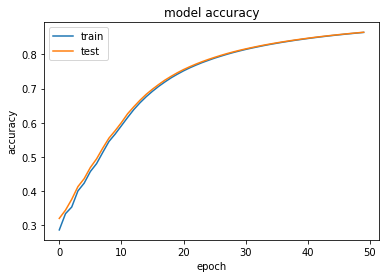

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
plt.plot(hist.history['categorical_accuracy'])
plt.plot(hist.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

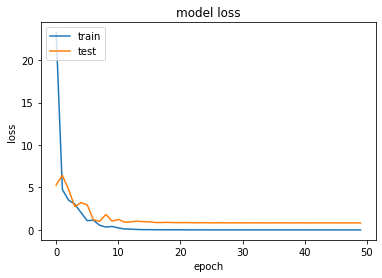

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

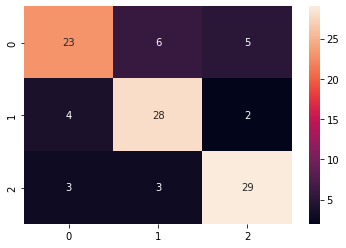

In [ ]:
import seaborn as sns
y_pred=model.predict(X_val) 
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_val, axis=1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)

#print(cm)

In [ ]:
accuracy_score(y_test,y_pred)

0.7766990291262136

In [ ]:
#model.save_weights('/content/drive/MyDrive/VGG_PECLESS_RF')

In [ ]:
#model3 = generate_vgg_model(l_e.classes_.size)


In [ ]:
RF_model3.load_weights('/content/gdrive/MyDrive/VGG_PECLESS_RF')


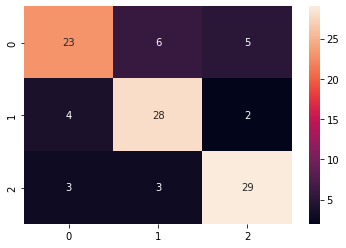

In [ ]:
y_pred=model.predict(X_val) 
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_val, axis=1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)

In [ ]:
X_train, X_test, y_train, y_test = dataset_stratified_split(split=0.20, dataset=images, labels=labels)


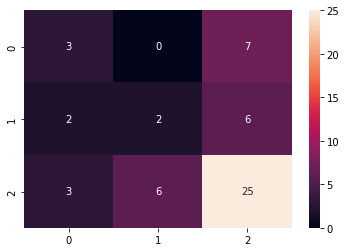

In [ ]:
y_pred=model.predict(X_test) 
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)

In [ ]:
accuracy_score(y_test,y_pred)

0.5555555555555556

In [ ]:
#rf_model=model.predict(X_train)

In [ ]:

RF_model.fit(X_RF, y_train) 
X_test_feature = model.predict(X_test)
prediction_RF = RF_model.predict(X_test_feature)


In [ ]:
prediction_RF[0]

array([0., 0., 1.], dtype=float32)

In [ ]:
pred_rf=np.argmax(prediction_RF, axis=1)
pred_rf


array([2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 0, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2,
       1, 2, 2, 0, 2, 1, 2, 2, 1, 2, 2, 0, 2, 0, 0, 2, 0, 2, 2, 2, 0, 1,
       2, 1, 2, 0, 2, 2, 0, 2, 0, 2])

In [ ]:
accuracy_score(y_test, pred_rf)


0.48148148148148145

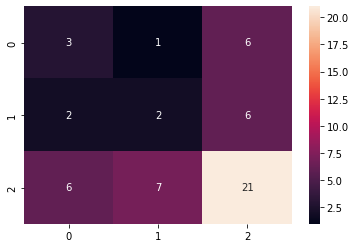

In [ ]:
cm = confusion_matrix(y_test, pred_rf)
sns.heatmap(cm, annot=True)